<h4><center>Trabajo Final - Optimización</center></h4>
<h4><center>Departamento de Matemática - FCEN</center></h4>
<h1><center>Aprendizaje por refuerzo</center></h1>
<h3><center>Integrantes</center></h3>
<center> Julio Padra, Ayelén Campero y José Castagnino </center>

<h1><center>Introducción</center></h1>
<!---
Elegimos tabajar sobre Reinforcment Learning ya que es una forma de aprendizaje automatizado que no está tan difundida como otras. Se basa en la idea de aprender mediante la interacción con el ambiente.
-->
En un típico escenario de aprendizaje por refuerzo, un agente pasará del estado $s$ al estado $s'$ luego de realizar la acción $a$ obteniendo una recompensa $r$ que retroalimenta al agente, como podemos ver en el diagrama.

De esta manera nuestro agente va aprendiendo llegando a los distintos estados y obteniendo las correspondientes recompensas.

<div>
<center>
<img src="reinforcement_learning.png" width="420"/>
<figcaption align = "center"> Diagrama de interacción agente-ambiente en un proceso de desición de Markov. </figcaption>
</center>
</div>

Ésta interacción genera una sucesión de estados, acciones y recompensas, que llamaremos $\{S_t, A_t, R_t\}$ para cada tiempo $t$

Para lograr que el agente aprenda del ambiente, hay dos maneras de hacerlo, dependiendo de si el agente conoce al detalle su ambiente o sólo parcialmente.

##### Aprendizaje reforzado basado en modelos:

Cuando se conoce en detalle el ambiente y sus reglas de juego tendremos un algoritmo de aprendizaje reforzado basado en modelos. Un ejemplo de un modelo de un ambiente es precisamente el ejemplo 4.1 del libro, ya que con antelación el agente puede conocer las reglas del juego, los movimientos que puede realizar y el tamaño del tablero. Con este modelo el agente puede planear con antelación su siguiente movida, y puede analizar las implicaciones de este movimiento o elegir otras alternativas.

El problema de este tipo de algoritmos es que sólo en contadas aplicaciones se tiene toda la información para construir un modelo del ambiente. En la mayoría de las aplicaciones reales sólo se tiene acceso parcial, y en estos casos hablamos de aprendizaje reforzado libre de modelos, al que pertenecen la mayor parte de los algoritmos usados en la actualidad.

##### Aprendizaje reforzado libre de modelos:

En este caso el agente debe aprender a tomar las decisiones por prueba y error, pues no conoce todos los detalles del ambiente. En realidad sólo tiene acceso a dos elementos: los estados y la recompensa resultante de sus acciones. Es por esto que debemos definir una política para que siga el agente.

##### La Política en el Aprendizaje Reforzado:
Una politica define como se comportará el agente en un momento determinado. En lineas generales, una política es una asociación entre los estados que el agente percibe del ambiente y las acciones que debe tomar cuando se encuentra en esos estados.

Si el agente está siguiendo la política $\pi$ en el momento $t$, entonces $\pi (a|s)$ es la probabilidad de realizar la acción $a$, dado que está en el estado $s$ a tiempo $t$. En definitiva, una política es un mapeo entre los estados y las probabilidades de seleccionar cada posible acción.

#### Mejora de la política
Para ésto utilizamos las *Ecuaciones de Bellman* tanto para calcular el valor de nuestra **política** a través de un método de punto fijo como para ir mejorando de manera iterativa nuestra **política**.
Nos resultó sorprendente lo amplio que puede ser el modelo, en el sentido de que problemas muy diversos pueden resolverse utilizándolo.

#### Observación
A su vez si bien el libro aclaraba que el método de resolución utilizando programación dinámica es bueno en el sentido teórico pero deficiente desde el punto de vista de la implementación, en nuestros ejemplos obtuvimos buenos resultados en diversos escenarios y con tiempos de corrida razonables.

## El ejemplo

El ejemplo es el 4.1 del libro, también llamado Grid World, en el que un agente se mueve en un tablero como el siguiente en busca de alguna de las salidas o posiciones terminales coloreadas en gris.

<div>
<center>
<img src="grid_world.png" width="420"/>
<figcaption align = "center"> Ambiente para el juego Grid World. </figcaption>
</center>
</div>

<br>
</br>

La recompensa $R$ está fija valiendo $-1$ para cada movimiento y el objetivo es maximizar el valor esperado de la ganancia, que viene dada por la suma de las recompensas acumuladas. Nos basamos en la propuesta del libro que busca un punto fijo en la ecuación de Bellman. Para ésto implementamos el pseudocódigo propuesto en el libro.

<br>
</br>

<div>
<center>
<img src="rutinas.png" name="rutinas" width="666"/>
<figcaption align = "center"> Algoritmo para mejorar la política. </figcaption>
</center>
</div>

# Nuestro modelo

Como primera medida, para ayudarnos en la notación definimos un orden para las acciones que utilizaremos con frecuencia en las rutinas de mejora de la política. El orden lo guardamos en el diccionario `ACTIONS@constants.py`. Las `keys` son las acciones y los `values` el orden asignado (notar que es un mapa 1 a 1).

In [1]:
from src.reinforcement_lenin.constants import ACTIONS
print("Las acciones y su orden")
for a, o in ACTIONS.items(): print(f"{o}: '{a}'")

Las acciones y su orden
0: 'left'
1: 'up'
2: 'right'
3: 'down'


#### Para modelar el ambiente de nuestro problema diseñamos el objeto `Board`, cuyos atributos principales son dos:

#### `Board.board`:
El tablero del juego con sus jugadas legales (i.e.) los movimientos que el agente puede realizar siguiendo las reglas del juego. Está representado como un diccionario de diccionarios (ejemplo para un tablero de 4x4)

In [2]:
from src.reinforcement_lenin.grid import Board
dict(sorted(Board(4).board.items()))  # para ver los nodos ordenados :p

{0: {},
 1: {'left': 0, 'up': 1, 'right': 2, 'down': 5},
 2: {'left': 1, 'up': 2, 'right': 3, 'down': 6},
 3: {'left': 2, 'up': 3, 'right': 3, 'down': 7},
 4: {'left': 4, 'up': 0, 'right': 5, 'down': 8},
 5: {'left': 4, 'up': 1, 'right': 6, 'down': 9},
 6: {'left': 5, 'up': 2, 'right': 7, 'down': 10},
 7: {'left': 6, 'up': 3, 'right': 7, 'down': 11},
 8: {'left': 8, 'up': 4, 'right': 9, 'down': 12},
 9: {'left': 8, 'up': 5, 'right': 10, 'down': 13},
 10: {'left': 9, 'up': 6, 'right': 11, 'down': 14},
 11: {'left': 10, 'up': 7, 'right': 11, 'down': 15},
 12: {'left': 12, 'up': 8, 'right': 13, 'down': 12},
 13: {'left': 12, 'up': 9, 'right': 14, 'down': 13},
 14: {'left': 13, 'up': 10, 'right': 15, 'down': 14},
 15: {}}

Las `keys` son los estados (los casilleros del tablero) y en `values` hay otro diccionario que contiene el estado al cual se llega siguiendo cada una de las acciones.

#### `Board.policy`
Define la política $\pi$ adoptada por el agente, representada como la matriz $\texttt{policy} \in \mathbb{R}^{N\times4} $. La matriz tendrá en $\texttt{policy[i][j]}$ la probabilidad de tomar la acción $j$ estando en el estado $i$. Para el caso de las acciones, usamos el como índice el orden que definimos en `ACTIONS`.

Por ejemplo, para el tablero de 4x4 con una política uniformemente distribuida, la matriz se verá así:

In [3]:
Board(4).policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

El método principal de nuestro objeto es el que mejora iterativamente la política de un agente y lo veremos en detalle más adelante.
Por otro lado, incluímos métodos para visualizar el tablero para una política dada. Por ejemplo para el tablero de la imagen anterior, tenemos

<h1>Optimización de la política</h1>

Nuestro tablero es inicializado siempre con la política uniformemente distribuia como la que vimos recién, y el objetivo es 
ir modificando esta política de manera iterativa. Para esto precisamos primero poder evaluar una política dada, esto es obtener 
a partir de la política los retornos esperados siguiendo $\pi$ a partir de cada uno de los estados.

Una de las rutinas que implementamos `Board.evaluate_policy()`, es el denominado *iterative policy evaluation* (el punto 2 del algoritmo en la figura 3), que calcula $v_\pi(s)$. Recordemos que, según el libro, esta viene definida recursivamente por
$$
v_0(s) = 0 \ \ \forall s \in S;
$$
$$
\begin{align}
v_{k+1}(s) & = \mathbb{E}_\pi \big[R_{t+1} + \gamma v_k(s+1) \ | \ S_t = s \big] \\ 
& = \sum_a \pi(a|s) \sum_{s',r} p(s', r | s, a) [r + \gamma v_k(s')]:
\end{align}
$$
valiéndose de que es un punto fijo de las ecuaciones de Bellman, es decir, $\{v_k\}_k \to v_\pi$ cuando $k$ tiende a infinito.

El método principal es `Board.iterate_policy()`, que implementa el resto del algoritmo de la figura 3 llamando al anterior para encontrar una política óptima para el juego.

### Caso testigo

A continuación mostramos los resultados para el caso 4x4. Para verificar con rapidez los resultados de una corrida cualquiera, agregamos a nuestro objeto métodos para visualizar el tablero con una política dada. Decidimos representar el tablero como un grafo dirigido y darle a las aristas un grosor correspondiente a las probabilidades dadas por la política. De esta manera es fácil evaluar la efectividad de una política viendo el dibujo.

Política óptima obtenida: 
 [[0.25 0.25 0.25 0.25]
 [1.   0.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.   1.   0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.5  0.5 ]
 [0.   0.   0.   1.  ]
 [0.   0.5  0.5  0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.25 0.25 0.25 0.25]]


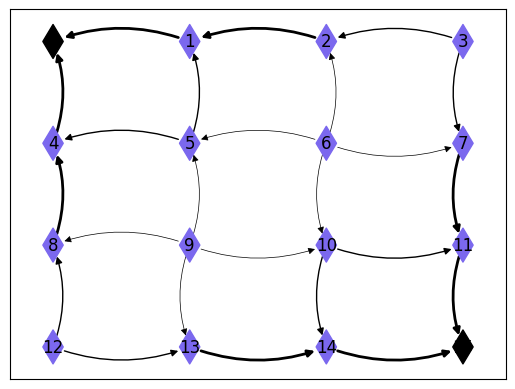

In [4]:
board = Board(4)
politica_optima = board.iterate_policy()
print(f"Política óptima obtenida: \n {politica_optima}")
board.draw_policy()

Se pueden ver las diferencias entre nuestra solución y la que aparece en el libro, en particular en los nodos (casilleros) 7 y 10, aunque en ambos casos se trata de políticas óptimas.

<div>
<center>
<img src="burton-policy.png" width="320"/>
<figcaption align = "center"> Política óptima del libro, p/77. </figcaption>
</center>
</div>

### Casos no triviales
El ejemplo del libro se reduce al análisis en el caso en que
1. La dimensión del tablero es $4 \times 4$.
2. Hay dos nodos terminales ubicados en las esquinas.
3. La recompensa es uniforme.


Si bien nos sirvió como guía para empezar nuestra implementación, la hicimos de manera que no solamente sirviera para resolver éste ejemplo. Veamos algunos ejemplos con tableros y reglas distintas.

#### 1: Las dimensiones
Nuestra propuesta permite modelar tableros de tamaño arbitrariamente grande (dado suficiente poder de cómputo) a través del parámetro `N`. Éste controla el largo del tablero, es decir que tendrá un total de  `N`² casilleros (estados).

#### 2: Estados terminales
La elección de los nodos terminales resulta determinante en el modo que adopta el juego y la política a implementar. En el caso del libro, además de estar limitado en la cantidad de nodos, estos tenían un lugar privilegiado y fijo que le da al juego una simetría intrínseca. Al permitir elegir cualquier estado como terminal.

#### 3: Las recompensas
Para todos los estados y todas las acciones, se pueden configurar distintas recompensas, permitiendo cualquier configuración pasando una matriz de recompensas $\texttt{reward} \in \mathbb{R}^{N\times4}$

## Ejemplos

#### 1: Tablero de 5x5 con un nodo terminal en el medio y recompensa constante -1

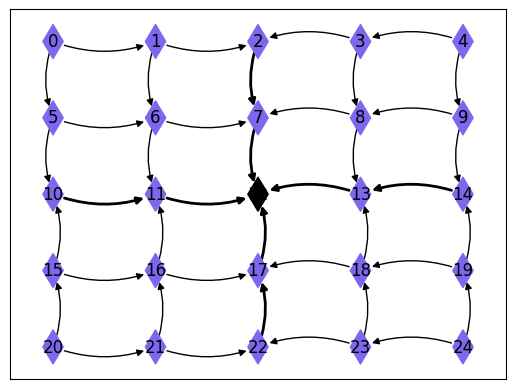

In [5]:
ejemplo_1 = Board(5, terminals=12)
ejemplo_1.iterate_policy()
ejemplo_1.draw_policy()

#### Ejemplo 2
##### Tablero 5x5 recompensas constantes y nodo terminal no central

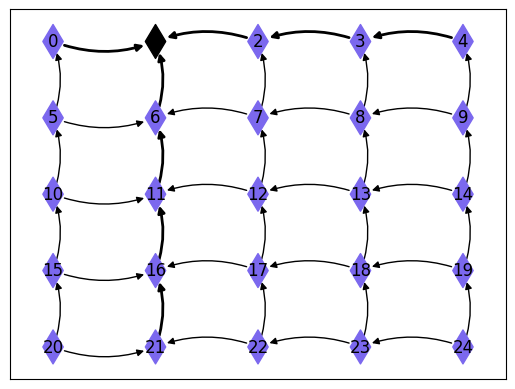

In [6]:
ejemplo_2 = Board(5, terminals=1)  # es el segundo nodo
ejemplo_2.iterate_policy()
ejemplo_2.draw_policy()

#### Ejemplo 3: Con distintas recompensas
##### Todas recompensas -1 salvo el estado 7 y la acción 'abajo' vale 2

Configuramos una matriz de recompensas con un valor dominante. En este caso quiere maximizar la esperanza de la ganancia y entra en un loop, nunca llegando a las salidas.

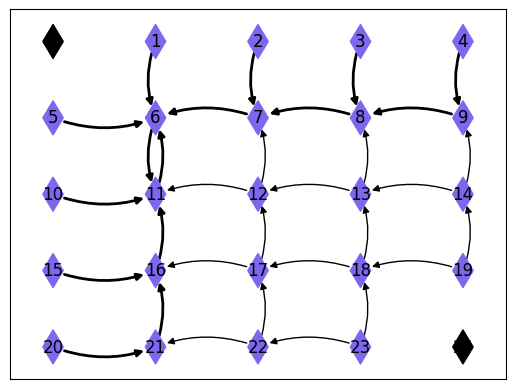

In [7]:
import numpy as np
rewards = -np.ones((25, 4))
rewards[6][3] = 2  # todas recompensas -1 salvo el estado 7 y la acción 'abajo' vale 2

ejemplo_3 = Board(5, reward=rewards)
ejemplo_3.iterate_policy()
ejemplo_3.draw_policy()

#### Ejemplo 4
##### Todas recompensas -1 salvo el estado 2 y la acción 'abajo' vale 2

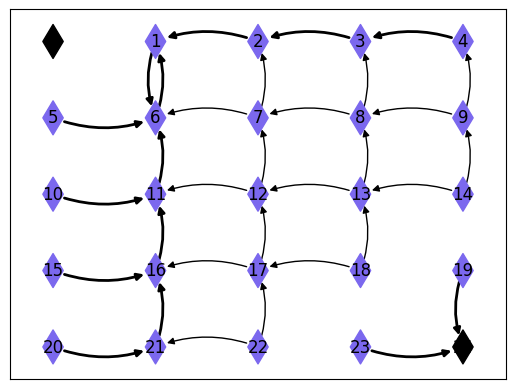

In [8]:
rewards = -np.ones((25, 4))
rewards[1][3] = 2

ejemplo_4 = Board(5, reward=rewards)
ejemplo_4.iterate_policy()
ejemplo_4.draw_policy()

#### Ejemplo 5: con más de dos nodos terminales

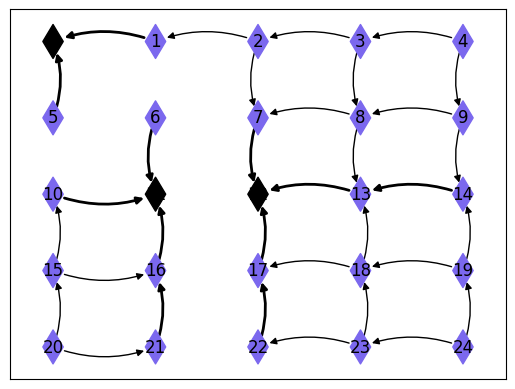

In [9]:
ejemplo_5 = Board(5, terminals=[0, 11, 12])
ejemplo_5.iterate_policy()
ejemplo_5.draw_policy()

#### Ejemplo 6: un tablero más grande

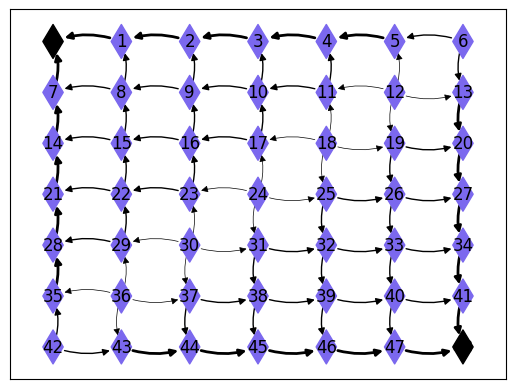

In [11]:
ejemplo_6 = Board(7)
ejemplo_6.iterate_policy()
ejemplo_6.draw_policy()

#### Ejemplo 7: algún casillero muy caro

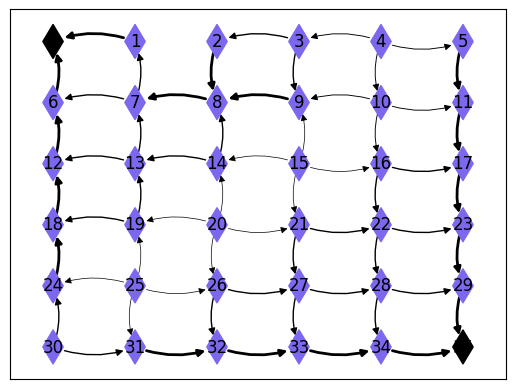

In [16]:
rewards = -np.ones((36, 4))
rewards[2][0] = -29

ejemplo_7 = Board(6, reward=rewards)
ejemplo_7.iterate_policy()
ejemplo_7.draw_policy()

# Desafíos
Las generalizaciones que nos quedaron pendientes incluyen por un lado la de tener una función de probabilidad más compleja, es decir que sea una variable aleatoria en vez de estar determinada. Y por el otro, la de que las acciones nos lleven hacia distintos estados futuros probables y cuyas recompensas también tengan una naturaleza estocástica.

# Backlog:

- [x] Intro a reinforcement learning (ecuación de B*llmn)
- [x] El ejemplo 4.1: Grid World
- [x] Nuestro modelo
    - [x] board y politica. 
    - [x] Rutinas (evaluación y mejora de la politica)
- [x] Nodos terminales y tamaño
- [x] Implementación del reward
- [] Conclusiones
- [] Hacer análisis de complejidad.